# Self-Supervised Monocular Depth-Estimation using Neural-Networks
## Jeremy Cheuk-To YU (20733516)

# Abstract
Depth estimation is well-studied subject in computer vision, with methods such as multi-view stereo/geometry, structure-from-motion able to provide very good result on depth information or 3D reconstruction. However, most of these methods rely on observations from multiple viewpoints of the scene, which is not always available. Depth information can also be obtained using 3D or depth scanning tools, which can be expensive.

In 2017, a method was proposed to use a convolutional neural network to predict the disparity map for an image simply using a rectified stereo image as training input (Godard et al., 2017). By using the left image as input and produce a disparity map for the left image, a reconstructed version of the left image can be obtained by combining the left disparity map and the right image, which can be compared with the original left image. This provides an end-to-end loss function for training the neural network. An improved version modifies the neural network to predict both the left and right disparity map simply from the left image, and enforced consistency between the two disparity maps, which is able to reduce some texture-copy artifacts. After training, the network can then be used to predict the disparity map from single (monocular) images. From the paper:

<img src="images/architecture.jpg"/>

This project attempts to implement the simplified (No LR) version, using the KITTI dataset, which is one of the dataset used in the original paper. The KITTI dataset provides individual image frames from rectified stereo videos from cameras mounted on a vehicle, along with 3D scanned data from a Velodyne scanner (Geiger et al., 2013).

# Code Libraries
The following notable code libraries are used for the project:
* *matplotlib* - https://matplotlib.org/ - conda install matplotlib  
A popular data plotting library.
* *pykitti* - https://github.com/utiasSTARS/pykitti - pip install pykitti  
A wrapper for specificly parsing the data from the KITTI Dataset.
* *pytorch_ssim* - https://github.com/Po-Hsun-Su/pytorch-ssim - in */extlibs*  
A structural similarity index measure (SSIM) implementation for PyTorch.
* *torch* - https://pytorch.org/ - https://pytorch.org/get-started/locally/  
A popular machine learning framework.

In [2]:
import copy
import glob
import os
import random
import numpy as np

# Notable code libraries
import matplotlib.pyplot as plt
import pykitti
import extlibs.pytorch_ssim as ssim

# PIL, PyTorch and TorchVision libraries
import PIL
from PIL import Image, ImageOps
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as tF

# Set to True if using GPU
USE_GPU = True

# Data Loading
## KITTI Dataset
The KITTI dataset is used for this project. It consists of videos taken from cameras mounted on a vehicle, and the raw image frames can be obtained at their website (http://www.cvlibs.net/datasets/kitti/raw_data.php). Each video is consist of both grayscale and colored image frame pairs, and scanned depth data in 3D coordinates. Each videos comes in two versions:
* unsynced and unrectified at full resolution; or 
* synced and rectified, but downscaled a little bit.

Since this project deals with disparities in the x-direction, synced and rectified images are downloaded along with the camera calibration data. In total, the size of the synced and rectified data comes to around 175GB. To reduce the scale of this project and save some download time, only the videos in the following cell are selected and used, which I have manually removed:
* long videos (>800 frames), to prevent the neural network from overfitting to them, since they will make up a larger portion of the training set; and
* videos with long period of still frames (e.g. stopping in front of traffic lights), to prevent the network from overfitting to them as well.

To reduce training time, the images are downscaled 2x in both width and height, and converted to JPEG to reduce image loading time. Unnecessary data such as the grayscaled image pairs or scanned depth data for the training set can also be deleted. After consolidation, the total size of the dataset used for this project comes to around 2.4GB. The zip of the dataset used in this project is uploaded to Google Drive at 1.7GB: https://drive.google.com/file/d/1lbncQwCkKEI_uvdcJh4KrOzakfa5lOlU/view?usp=sharing. Simply unzip the content into the dataset folder.

Every 10th video is separated as validation data, which will be used to check for overfitting after training each epoch.

In [3]:
# File path information for the KITTI Dataset
DATASET_PATH = 'dataset'
DATA_PATH = '2011_09_26'

OVERFIT_PATH = ['0020']
# Manually separates training and validation dataset
TRAINING_PATH = [ \
                 '0001', '0002', '0005', '0009', '0011', '0013', '0014', '0015', '0019', \
                 '0022', '0023', '0027', '0028', '0029', '0032', '0035', '0036', '0039', \
                 '0028', '0052', '0056', '0059', '0061', '0064', '0070', '0079', '0086', \
                 '0091', '0093', '0095', '0096', '0101', '0104', '0106', '0113', '0117']
VALIDATION_PATH = ['0020', '0046', '0087']

# All images in the dataset is the same size (original size is 1242x375), 
# and is resized to a smaller size to scale down the project to a reasonable running time.
IMAGE_SIZE_ORIGINAL = (375, 1242)
IMAGE_SIZE = (IMAGE_SIZE_ORIGINAL[0] // 2, IMAGE_SIZE_ORIGINAL[1] // 2)
IMAGE_SIZE_RATIO = (IMAGE_SIZE[0] / IMAGE_SIZE_ORIGINAL[0], IMAGE_SIZE[1] / IMAGE_SIZE_ORIGINAL[1])

# PIL uses (width, height) instead of (height, width)
image_size = (IMAGE_SIZE[1], IMAGE_SIZE[0])
lof = [filename for filename in glob.iglob(DATASET_PATH + '\**\*.png', recursive=True)]
for filename in lof:
    image = Image.open(filename)
    if (image.size[0] != image_size[0]):
        image = image.resize((IMAGE_SIZE[1], IMAGE_SIZE[0]))
    # Swap to JPEG to reduce file loading time later on
    image.save(filename[:-4] + '.jpg', format='JPEG')
    os.remove(filename)
print('Finished resizing images!')
    
count = sum([1 for _ in glob.iglob(DATASET_PATH + '\**\*.jpg', recursive=True)]) // 2
print('Total image pairs: {}'.format(count))

Finished resizing images!
Total image pairs: 14240


In [4]:
# Custom PyTorch dataset for the KITTI Dataset
class KITTIDataset(Dataset):
    # dataset_path, data_path, drive_paths: file path segments for the KITTI Dataset
    # transform: data augmentation applied to each image pair
    # one_pair: only contains the first image pair if True, for samples and overfit net purposes
    def __init__(self, dataset_path, data_path, drive_paths, transform=None, one_pair=False):
        self.datas = []
        self.indices_lookup = []
        self.transform = transform
        for i in range(len(drive_paths)):
            if (one_pair):
                data = pykitti.raw(dataset_path, data_path, drive_paths[i], frames=[0], imtype='jpg')
            else:
                data = pykitti.raw(dataset_path, data_path, drive_paths[i], imtype='jpg')
            self.datas.append(data)
            index = np.zeros((len(data), 2))
            if (len(self.indices_lookup) == 0):
                self.indices_lookup = np.zeros((len(data), 2), dtype='uint32')
                self.indices_lookup[:, 0] = i
                self.indices_lookup[:, 1] = np.arange(len(data))
            else:
                index = np.zeros((len(data), 2), dtype='uint32')
                index[:, 0] = i
                index[:, 1] = np.arange(len(data))
                self.indices_lookup = np.append(self.indices_lookup, index, axis=0)

    def __len__(self):
        return len(self.indices_lookup)

    def __getitem__(self, idx):
        if (isinstance(idx, int)):
            output_left, output_right = self.GetRawImage(idx)
            if self.transform:
                output_left, output_right = self.transform(output_left, output_right)
        else:
            output_left = []
            output_right = []
            for i in idx:
                img_left, img_right = self.GetRawImage(i)
                if self.transform:
                    img_left, img_right = self.transform(img_left, img_right)
                output_left.append(img_left)
                output_right.append(img_right)
            output_left = torch.cat(output_left)
            output_right = torch.cat(output_right)
            if (output_left.dim() == 3):
                output_left = output_left[None]
                output_right = output_right[None]
        return output_left, output_right
    
    # Get the raw image pair at idx
    def GetRawImage(self, idx):
        data = self.datas[self.indices_lookup[idx][0]]
        idx = self.indices_lookup[idx][1]
        return data.get_rgb(idx)

    # Get the ground truth data at idx
    def GetGroundTruth(self, idx):
        data = self.datas[self.indices_lookup[idx][0]]
        idx = self.indices_lookup[idx][1]

        # Get the 3D scanned data in world co-ordinate.
        scanned = data.get_velo(idx)
        # Set to homogeneous representation ([x, y, z, 1]).
        scanned[:, 3] = 1
        # Apply extrinsic camera matrices ([R|T]).
        scanned_left = (np.matmul(data.calib.T_cam2_velo, scanned.T)).T
        scanned_right = (np.matmul(data.calib.T_cam3_velo, scanned.T)).T
        scanned_left = scanned_left[:, :3] / scanned_left[:, 3, None]
        scanned_right = scanned_right[:, :3] / scanned_right[:, 3, None]
        # Apply intrinsic camera matrices (K).
        scanned_left = (np.matmul(data.calib.K_cam2, scanned_left.T)).T
        scanned_right = (np.matmul(data.calib.K_cam3, scanned_right.T)).T
        # Remove scanned dots in negative z since they are behind camera.
        scanned_left = scanned_left[scanned_left[:, 2] > 0]
        scanned_right = scanned_right[scanned_right[:, 2] > 0]
        # Scale down accordingly to the resized images.
        scanned_left[:, 0] = scanned_left[:, 0] * IMAGE_SIZE_RATIO[1]
        scanned_left[:, 1] = scanned_left[:, 1] * IMAGE_SIZE_RATIO[0]
        scanned_right[:, 0] = scanned_right[:, 0] * IMAGE_SIZE_RATIO[1]
        scanned_right[:, 1] = scanned_right[:, 1] * IMAGE_SIZE_RATIO[0]
        return scanned_left, scanned_right
    
    # Get the camera pair's baseline at idx
    def GetBaseline(self, idx):
        data = self.datas[self.indices_lookup[idx][0]]
        return data.calib.b_rgb
        
    # Get the camera pair's focal lengths at idx
    # Same for both cameras in both x and y direction
    def GetFocalLength(self, idx):
        data = self.datas[self.indices_lookup[idx][0]]
        # K[0][0]
        return data.calib.K_cam2[0][0]

## Data Augmentation
Similar data augmentations and ranges are used from the original paper, which consist of randomly flipping, and random changes in brightness, contrast, color, and saturation. Images are also normalized.

In [5]:
# Modified from A5
# Set to tensor format for the image pair
class JointToTensor(object):
    def __call__(self, img_left, img_right):
        return (tF.to_tensor(img_left), tF.to_tensor(img_right))
    
# Randomly (50%) flips the image pair
class JointRandomFlip(object):
    def __call__(self, img_left, img_right):
        if random.random() > 0.5:
            return (tF.hflip(img_right), tF.hflip(img_left))
        return (img_left, img_right)
    
# Abstract class that randomizes a factor in Uniform(a, b)
class JointRandomFactor(object):
    # a: minimum of the factor
    # b: maximum of the factor
    def __init__(self, a, b):
        self.a = a
        self.b = b
        
    # return: a random factor in Uniform(a, b)
    def factor(self):
        return random.uniform(self.a, self.b)
        
# Randomly changes the brightness of the image pair
class JointRandomBrightness(JointRandomFactor):
    def __call__(self, img_left, img_right):
        factor = self.factor()
        return (tF.adjust_brightness(img_left, factor), tF.adjust_brightness(img_right, factor))

# Randomly changes the contrast of the image pair
class JointRandomContrast(JointRandomFactor):
    def __call__(self, img_left, img_right):
        factor = self.factor()
        return (tF.adjust_contrast(img_left, factor), tF.adjust_contrast(img_right, factor))
    
# Randomly changes the color of the image pair
class JointRandomHue(JointRandomFactor):
    def __call__(self, img_left, img_right):
        factor = self.factor()
        return (tF.adjust_hue(img_left, factor), tF.adjust_hue(img_right, factor))
    
# Randomly changes the saturation of the image pair
class JointRandomSaturation(JointRandomFactor):
    def __call__(self, img_left, img_right):
        factor = self.factor()
        return (tF.adjust_saturation(img_left, factor), tF.adjust_saturation(img_right, factor))
    
# Normalizes the image pair
class JointNormalize(object):
    def __call__(self, img_left, img_right):
        return (tF.normalize(img_left, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), 
                tF.normalize(img_right, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]))
    
# Un-normalizes the image
class Unnormalize(object):
    def __call__(self, img):
        return (tF.normalize(img, [-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225], 
                             [1.0 / 0.229, 1.0 / 0.224, 1.0 / 0.225]))
    
# Applies multiple transforms to the image pair
class JointCompose(object):
    # transforms: list of transforms to apply
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img_left, img_right):
        assert img_left.size == img_right.size
        for t in self.transforms:
            img_left, img_right = t(img_left, img_right)
        return img_left, img_right

In [6]:
training_transform = JointCompose([
    JointToTensor(), 
    JointRandomFlip(), 
    JointRandomBrightness(0.8, 1.2), 
    JointRandomContrast(0.8, 1.2), 
    JointRandomHue(-0.1, 0.1), 
    JointRandomSaturation(0.8, 1.2), 
    JointNormalize()
])

validation_transform = JointCompose([
    JointToTensor(), 
    JointNormalize()
])

# Increase as much as you can if you are using GPU!
TRAINING_BATCH_SIZE = 48
VALDIATION_BATCH_SIZE = 24

overfit_dataset = KITTIDataset(DATASET_PATH, DATA_PATH, OVERFIT_PATH, transform=training_transform, one_pair=True)
overfit_loader = DataLoader(overfit_dataset, batch_size=1, num_workers=0, shuffle=True)
print('Total image pairs in overfit_dataset: {}'.format(len(overfit_dataset)))
training_dataset = KITTIDataset(DATASET_PATH, DATA_PATH, TRAINING_PATH, transform=training_transform)
train_loader = DataLoader(training_dataset, batch_size=TRAINING_BATCH_SIZE, num_workers=0, shuffle=True)
print('Total image pairs in training_dataset: {}'.format(len(training_dataset)))
validation_dataset = KITTIDataset(DATASET_PATH, DATA_PATH, VALIDATION_PATH, transform=validation_transform)
val_loader = DataLoader(validation_dataset, batch_size=VALDIATION_BATCH_SIZE, num_workers=0, shuffle=False)
print('Total image pairs in validation_dataset: {}'.format(len(validation_dataset)))

Total image pairs in overfit_dataset: 1
Total image pairs in training_dataset: 13708
Total image pairs in validation_dataset: 940


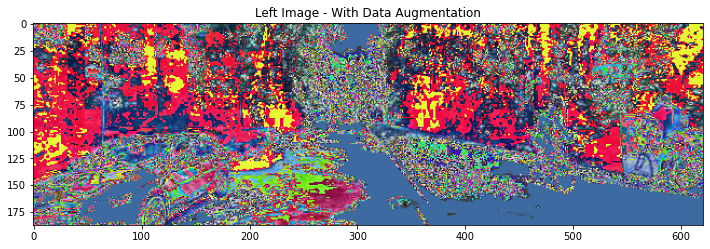

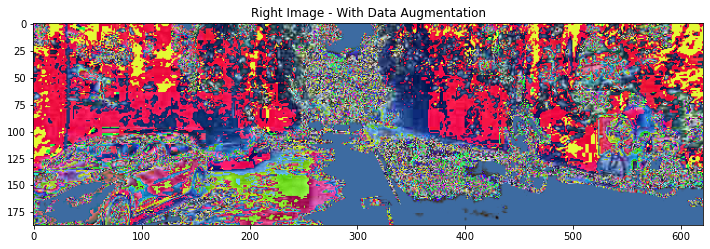

In [6]:
%matplotlib inline

sample_left, sample_right = overfit_dataset[[0]]

fig = plt.figure(figsize=(12,6))
plt.title('Left Image - With Data Augmentation')
fig.gca().imshow(tF.to_pil_image(sample_left[0]))
plt.show()

plt.figure(figsize=(12,6))
plt.title('Right Image - With Data Augmentation')
plt.imshow(tF.to_pil_image(sample_right[0]))
plt.show()

## Ground Truth
As shown below, after projecting the 3D depth information back to the image, the ground truth is quite sparse, missing the top half and is ill-suited to be used as supervision to the training, which illustrates the need for the self-supervision in depth estimation problems.

For all images shown in this project, the colormap *magma* will be used, and lighter color will always mean closer (lower depth or larger pixel disparity).

Baseline: 0.5327254400790535m
Focal Length: 721.5377m


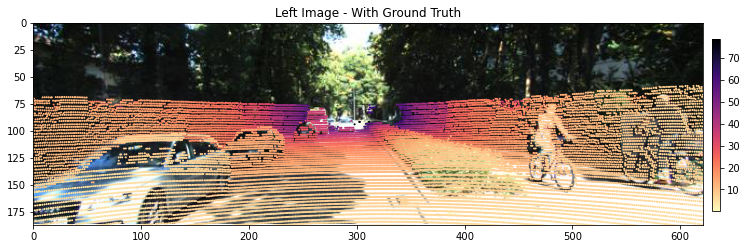

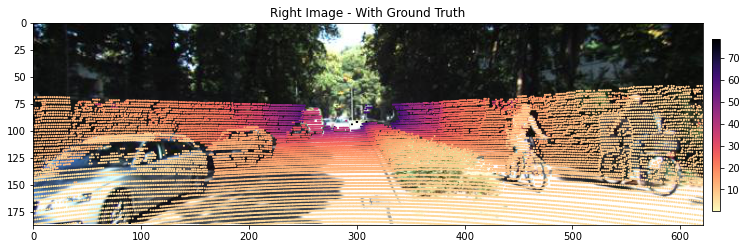

In [14]:
%matplotlib inline

def PlotGroundTruth(plt, img, scanned_img):
    plt.imshow(img)
    plt.scatter(scanned_img[:, 0] / scanned_img[:, 2], 
                scanned_img[:, 1] / scanned_img[:, 2], 
                c=scanned_img[:, 2], s=1, cmap='magma_r')
    axes = plt.gca()
    axes.set_xlim([0, img.width])
    axes.set_ylim([img.height, 0])
    plt.colorbar(cax=plt.axes([0.91, 0.3, 0.01, 0.4]))
    
sample_left, sample_right = overfit_dataset.GetRawImage(0)
sample_scanned_left, sample_scanned_right = overfit_dataset.GetGroundTruth(0)
print("Baseline: {}m".format(overfit_dataset.GetBaseline(0)))
print("Focal Length: {}m".format(overfit_dataset.GetFocalLength(0)))

plt.figure(figsize=(12,6))
plt.title('Left Image - With Ground Truth')
PlotGroundTruth(plt, sample_left, sample_scanned_left)
plt.show()

plt.figure(figsize=(12,6))
plt.title('Right Image - With Ground Truth')
PlotGroundTruth(plt, sample_right, sample_scanned_right)
plt.show()

# Training and Validation
## Architecture
In the original paper, the neural network employs a standard UNet architecture. The encoder consist of the pretrained 5 conv2d layers from ResNet50, and the decoder consist of 5 levels of up-convolutions, skip-connections, and convolutions, with exponential linear units (ELU) in between and sigmoid activation function at the end.

ELUs were found to provide a better convergence instead of rectified linear units (ReLU) in the original paper. Sigmoid was used at the end to fix the final values below 1, and the final pixel disparity was obtained by multiplying it with a maximum allowed pixel disparity.

Due to limited training time, this project uses ResNet18, and only the 4 first pretrained conv2d layers are used due to the resized image. The decoder correspondingly has 4 layers of the same architecture proposed by the original paper.

In [7]:
import torchvision.models as models

# The maximum allowed pixel disparity
# A higher maximum disparity will result in longer training time
MAX_DISPARITY = 0.2 * IMAGE_SIZE[1]

class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        
        # encoder
        resnet18_modules = list(models.resnet18(pretrained=True).children())
        self.conv1 = nn.Sequential(*(resnet18_modules[:4]))
        self.conv2_x = nn.Sequential(resnet18_modules[4])
        self.conv3_x = nn.Sequential(resnet18_modules[5])
        self.conv4_x = nn.Sequential(resnet18_modules[6])
        self.conv5_x = nn.Sequential(resnet18_modules[7])
        
        # decoder
        self.upconv4_d = nn.ConvTranspose2d(256, 128, 3, 1)
        self.conv4_d = nn.Conv2d(256, 128, 3, 1)
        self.upconv3_d = nn.ConvTranspose2d(128, 64, 3, 1)
        self.conv3_d = nn.Conv2d(128, 64, 3, 1)
        self.upconv2_d = nn.ConvTranspose2d(64, 32, 3, 1)
        self.conv2_d = nn.Conv2d(96, 32, 3, 1)
        self.upconv1_d = nn.ConvTranspose2d(32, 16, 3, 1)
        self.conv1_d = nn.Conv2d(16, 1, 3, 1, padding=(1, 1))
        
        self.ELU = nn.ELU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, inp, gts=None):
        conv1_e = self.conv1(inp)
        conv2_e = self.conv2_x(conv1_e)
        conv3_e = self.conv3_x(conv2_e)
        conv4_e = self.conv4_x(conv3_e)
        conv4_d = self.ELU(self.upconv4_d(conv4_e))
        conv4_d = nn.Upsample(size=(conv3_e.shape[2], conv3_e.shape[3]), mode='nearest')(conv4_d)
        conv4_d = torch.cat((conv4_d, conv3_e), 1)
        conv3_d = self.ELU(self.conv4_d(conv4_d))
        conv3_d = self.ELU(self.upconv3_d(conv3_d))
        conv3_d = nn.Upsample(size=(conv2_e.shape[2], conv2_e.shape[3]), mode='nearest')(conv3_d)
        conv3_d = torch.cat((conv3_d, conv2_e), 1)
        conv2_d = self.ELU(self.conv3_d(conv3_d))
        conv2_d = self.ELU(self.upconv2_d(conv2_d))
        conv2_d = nn.Upsample(size=(conv1_e.shape[2], conv1_e.shape[3]), mode='nearest')(conv2_d)
        conv2_d = torch.cat((conv2_d, conv1_e), 1)
        conv1_d = self.ELU(self.conv2_d(conv2_d))
        conv1_d = self.ELU(self.upconv1_d(conv1_d))
        conv1_d = nn.Upsample(size=(inp.shape[2], inp.shape[3]), mode='bilinear', align_corners=False)(conv1_d)
        output = self.sigmoid(self.conv1_d(conv1_d))
        return output

In [9]:
untrained_net = MyNet()
torch.save(untrained_net.state_dict(), 'untrained.dat')

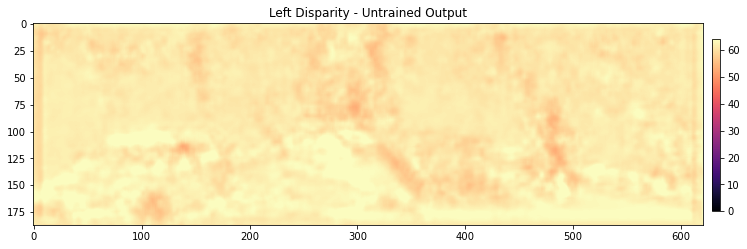

In [10]:
%matplotlib inline

sample_left, sample_right = overfit_dataset[[0]]

untrained_net = MyNet()
untrained_net.load_state_dict(torch.load('untrained.dat'))
untrained_net.eval()
untrained_output = untrained_net.forward(sample_left)

plt.figure(figsize=(12,6))
plt.title('Left Disparity - Untrained Output')
plt.imshow(untrained_output[0].view(IMAGE_SIZE).detach().numpy() * MAX_DISPARITY, 
           vmin=0, vmax=torch.quantile(untrained_output.flatten() * MAX_DISPARITY, 0.95), cmap='magma')
plt.colorbar(cax=plt.axes([0.91, 0.3, 0.01, 0.4]))
plt.show()

## Training Loss
The training loss is similar to the original paper. Let $I$ be the original left image, $I'=d(I_R)$ be the reconstructed image from applying the left disparity to the right image, the total loss is the following:

$$\alpha\cdot-\text{SSIM}(I, I')+\beta\cdot\text{MSE}(I, I')+\gamma\cdot(\sum_{i,j}|d_{ij}-d_{(i+1)j}|e^{-||I_{ij}-I_{(i+1)j}||}+\sum_{i,j}|d_{ij}-d_{i(j+1)}|e^{-||I_{ij}-I_{i(j+1)}||})$$

 * The $\alpha, \beta$ terms are the photoconsistency terms, measuring the difference between the original and reconstructed left image. Structural simmilarity (SSIM) is a window-based robust similarity index designed with human visual perception in mind (Wang et al., 2004); while mean square error (MSE) is simply the square difference between each pixel. A negative SSIM maximizes the simmilarity.
 * The $\gamma$ term is the depth smoothness term. Similar to how it is implemented for scanline stereos, it penalizes large disparity discontinuity at low image gradient, and encourages disparity jumps when image gradient jumps.
 * The loss function is also averaged, so that it can be used for comparison between different batch sizes.

### Hyperparameters

$$\alpha=0.8, \beta=0.3, \gamma=5.0, \text{learning rate}=0.00075$$

The above values are used based on preliminary tests for the fastest convergence on the overfitted training test.

### Applying Disparity
Disparity is applied on the right image by adding the pixel disparity to a meshgrid of x indices, and projecting the right image to a new image with the modified x indices. Since the indices must be integers, instead of rounding out the pixel disparity, which will result in zero gradients, interpolation must be applied.

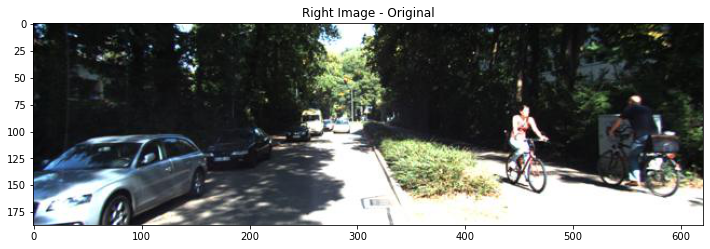

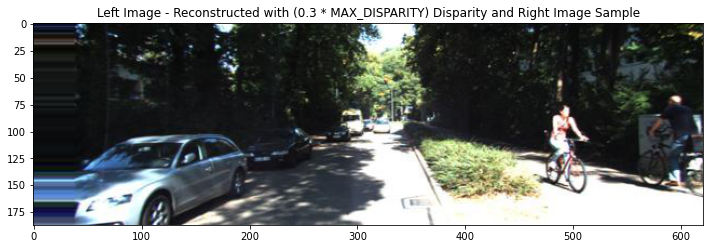

In [8]:
%matplotlib inline

# A helper meshgrid used in ApplyDisparity that is initialized once here
_, BASE_X_IDX = torch.meshgrid(torch.arange(IMAGE_SIZE[0]), torch.arange(IMAGE_SIZE[1]))
BASE_X_IDX = BASE_X_IDX.repeat(3, 1, 1).type(torch.FloatTensor)
if USE_GPU: BASE_X_IDX = BASE_X_IDX.to("cuda:0")

# Create a reconstructed (left) image by applying a (left) disparity map to a (right) image
# img: Original (right) image
# disp: (Left) disparity map
def ApplyDisparity(img, disp):
    if USE_GPU:
        img = img.to("cuda:0")
        disp = disp.to("cuda:0")
    x_idx = BASE_X_IDX.repeat(img.shape[0], 1, 1, 1)
    # Calculate the new x idx for each pixels
    # Since disp is a sigmoid'ed output, MAX_DISPARITY represents the maximum allowed pixel disparity
    x_idx -= disp * MAX_DISPARITY
    # Don't exceed the x limits!
    x_idx = torch.clamp(x_idx, 0, IMAGE_SIZE[1] - 1)
    # The new x idx has to be integers.
    # Interpolate to keep the returned values differentiable with meaningful slopes!
    if USE_GPU:
        x_idx_fl = torch.floor(x_idx).type(torch.cuda.LongTensor)
    else:
        x_idx_fl = torch.floor(x_idx).type(torch.LongTensor)
    x_idx_fl_1 = x_idx_fl + 1
    x_idx_fl_1 = torch.clamp(x_idx_fl_1, 0, IMAGE_SIZE[1] - 1)
    img_new_fl = torch.gather(img, 3, x_idx_fl)
    img_new_fl_1 = torch.gather(img, 3, x_idx_fl_1)
    return (x_idx_fl_1 - x_idx) * img_new_fl + (x_idx - x_idx_fl) * img_new_fl_1

# Total loss, as stated above
class TotalLoss(object):
    def __init__(self):
        self.ssim = ssim.SSIM(window_size=5)
        self.mse = nn.MSELoss()
        if USE_GPU:
            self.ssim = self.ssim.to("cuda:0")

    def __call__(self, img_l, img_r, disp):
        # Photoconsistency term
        pred_img_l = ApplyDisparity(img_r, disp)
        p_ssim = - self.ssim(img_l, pred_img_l)
        p_mse = self.mse(img_l, pred_img_l)
        # Depth smoothness term
        img_l_grad_y = torch.sum(torch.square(img_l - torch.roll(img_l, 1, 2)), 1)
        img_l_grad_x = torch.sum(torch.square(img_l - torch.roll(img_l, 1, 3)), 1)
        v_y = torch.abs(disp - torch.roll(disp, 1, 2)).view(-1, IMAGE_SIZE[0], IMAGE_SIZE[1]) * \
            torch.exp(- img_l_grad_y)
        v_x = torch.abs(disp - torch.roll(disp, 1, 3)).view(-1, IMAGE_SIZE[0], IMAGE_SIZE[1]) * \
            torch.exp(- img_l_grad_x)
        v_y = torch.mean(v_y)
        v_x = torch.mean(v_x)
        return 0.8 * p_ssim + 0.3 * p_mse + 5.0 * (v_x + v_y)
    
sample_img_r = tF.to_tensor(overfit_dataset.GetRawImage(0)[1])[None]
plt.figure(figsize=(12,6))
plt.title('Right Image - Original')
plt.imshow(tF.to_pil_image(sample_img_r[0]))
plt.show()

sample_disp_l_1 = torch.full((sample_img_r.shape[0], IMAGE_SIZE[0], IMAGE_SIZE[1]), 0.3)
sample_img_l_1 = ApplyDisparity(sample_img_r, sample_disp_l_1)
plt.figure(figsize=(12,6))
plt.title('Left Image - Reconstructed with (0.3 * MAX_DISPARITY) Disparity and Right Image Sample')
plt.imshow(tF.to_pil_image(sample_img_l_1[0]))
plt.show()

## Training and Validation Loop

In [9]:
def training_step(train_loader, loader_size, net, optimizer, criterion, loss_graph):
    print('Batch Done: ', end ='')
    for i, data in enumerate(train_loader):
        img_ls = data[0]
        img_rs = data[1]

        if USE_GPU:
            net = net.cuda()
            img_ls = img_ls.cuda()
            img_rs = img_rs.cuda()
        
        optimizer.zero_grad()
        pred_disp_ls = net(img_ls)
        loss = criterion(img_ls, img_rs, pred_disp_ls)
        loss.backward()
        optimizer.step()
        loss_graph.append(loss)
        print('.', end ='')
        
    print('')
    return loss

def train(train_loader, net, epoch, learning_rate, filename, save_every_epoch=0):
    criterion = TotalLoss()
    net.train()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    print("Starting Training...")

    loss_graph = []

    for e in range(epoch):
        loss = training_step(train_loader, len(train_loader.dataset), net, optimizer, criterion, loss_graph)
        np.save('{}.npy'.format(filename), loss_graph)
        print("Epoch: {} Loss: {}".format(e, loss))
        if (save_every_epoch != 0 and e % save_every_epoch == 0):
            torch.save(net.state_dict(), '{}.{}.dat'.format(filename, e))
    torch.save(net.state_dict(), '{}.{}.dat'.format(filename, epoch - 1))
    
def validate_step(validation_loader, net, criterion, loss_graph):
    print('Batch Done: ', end ='')
    losses = []
    for i, data in enumerate(validation_loader):
        img_ls = data[0]
        img_rs = data[1]

        if USE_GPU:
            net = net.cuda()
            img_ls = img_ls.cuda()
            img_rs = img_rs.cuda()
        
        pred_disp_ls = net(img_ls)
        loss = criterion(img_ls, img_rs, pred_disp_ls).item()
        losses.append(loss)
        print('.', end ='')
        
    print('')
    average_loss = sum(losses) / len(losses)
    loss_graph.append(average_loss)
    return average_loss

def validate(validation_loader, epoch, filename, save_every_epoch=0):
    criterion = TotalLoss()
    
    print("Starting Validation...")
    epochs = []
    loss_graph = []

    for e in range(epoch):
        if (save_every_epoch != 0 and e % save_every_epoch == 0):
            epochs.append(e)
            validation_net = MyNet()
            validation_net.load_state_dict(torch.load('{}.{}.dat'.format(filename, e)))
            validation_net.eval()
        average_loss = validate_step(validation_loader, validation_net, criterion, loss_graph)
        np.save('{}.val.npy'.format(filename), loss_graph)
        print("Epoch: {} Average Loss: {}".format(e, average_loss))

## Overfit Network
Trained with 1 image pairs on 100 epochs.

In [20]:
%%time
overfit_net = copy.deepcopy(untrained_net)
train(overfit_loader, overfit_net, 100, 0.00075, 'overfit_net')

Starting Training...
Batch Done: .
Epoch: 0 Loss: 0.4687136113643646
Batch Done: .
Epoch: 1 Loss: 0.26554548740386963
Batch Done: .
Epoch: 2 Loss: 0.12796089053153992
Batch Done: .
Epoch: 3 Loss: 0.0715070590376854
Batch Done: .
Epoch: 4 Loss: 0.1054408848285675
Batch Done: .
Epoch: 5 Loss: 0.1314963400363922
Batch Done: .
Epoch: 6 Loss: 0.02125905267894268
Batch Done: .
Epoch: 7 Loss: 0.0992022156715393
Batch Done: .
Epoch: 8 Loss: 0.1475462168455124
Batch Done: .
Epoch: 9 Loss: 0.14111079275608063
Batch Done: .
Epoch: 10 Loss: 0.1397266536951065
Batch Done: .
Epoch: 11 Loss: -0.002265673130750656
Batch Done: .
Epoch: 12 Loss: 0.0831553190946579
Batch Done: .
Epoch: 13 Loss: 0.032577160745859146
Batch Done: .
Epoch: 14 Loss: -0.12963750958442688
Batch Done: .
Epoch: 15 Loss: 0.03107321634888649
Batch Done: .
Epoch: 16 Loss: 0.062468938529491425
Batch Done: .
Epoch: 17 Loss: -0.00565868616104126
Batch Done: .
Epoch: 18 Loss: -0.09395197033882141
Batch Done: .
Epoch: 19 Loss: -0.0797429

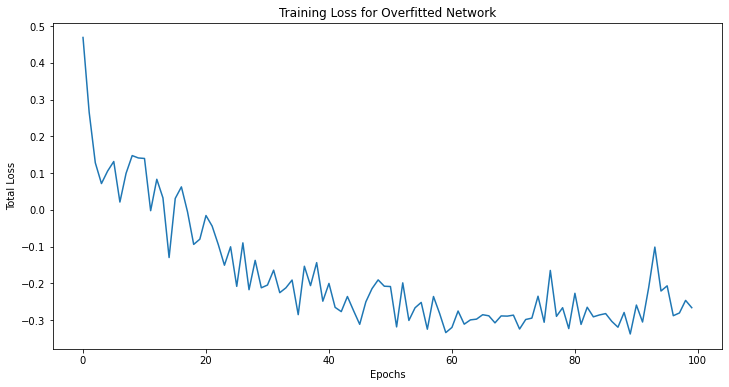

In [26]:
%matplotlib inline

loss_graph = np.load('overfit_net.npy', allow_pickle=True)
plt.figure(figsize=(12,6))
plt.title('Training Loss for Overfitted Network')
ax = plt.gca()
ax.set_xlabel('Epochs')
ax.set_ylabel('Total Loss')
plt.plot(loss_graph)
plt.show()

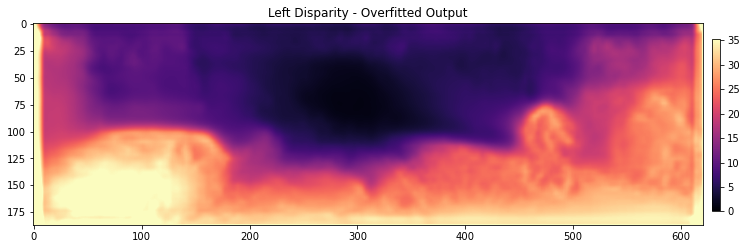

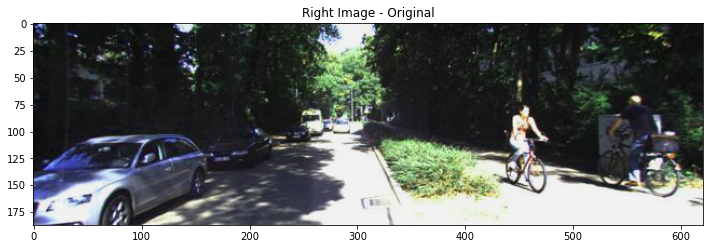

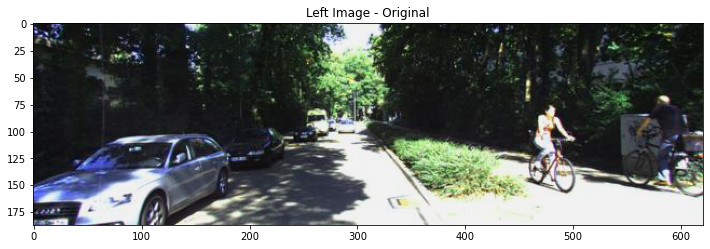

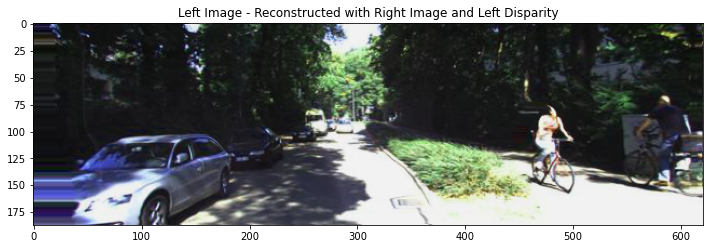

In [27]:
%matplotlib inline

sample_left, sample_right = overfit_dataset[[0]]

overfit_net = MyNet()
overfit_net.load_state_dict(torch.load('overfit_net.99.dat'))
overfit_net.eval()
overfit_output = overfit_net.forward(sample_left)

plt.figure(figsize=(12,6))
plt.title('Left Disparity - Overfitted Output')
plt.imshow(overfit_output.cpu()[0].view(IMAGE_SIZE).detach().numpy() * MAX_DISPARITY, 
           vmin=0, vmax=torch.quantile(overfit_output.flatten() * MAX_DISPARITY, 0.95), cmap='magma')
plt.colorbar(cax=plt.axes([0.91, 0.3, 0.01, 0.4]))
plt.show()

sample_right_gt = Unnormalize()(sample_right[0])
plt.figure(figsize=(12,6))
plt.title('Right Image - Original')
plt.imshow(tF.to_pil_image(sample_right_gt))
plt.show()

sample_left_gt = Unnormalize()(sample_left[0])
plt.figure(figsize=(12,6))
plt.title('Left Image - Original')
plt.imshow(tF.to_pil_image(sample_left_gt))
plt.show()

sample_left_pred = ApplyDisparity(sample_right, overfit_output)
sample_left_pred = Unnormalize()(sample_left_pred[0])
plt.figure(figsize=(12,6))
plt.title('Left Image - Reconstructed with Right Image and Left Disparity')
plt.imshow(tF.to_pil_image(sample_left_pred))
plt.show()

## Trained Network
Trained with 13708 image pairs, validated with 940 image pairs on 5 epochs.

In [28]:
%%time
train_net = copy.deepcopy(untrained_net)
train(train_loader, train_net, 8, 0.00075, 'train_net', save_every_epoch=1)

Starting Training...
Batch Done: ..............................................................................................................................................................................................................................................................................................
Epoch: 0 Loss: -0.3111402690410614
Batch Done: ..............................................................................................................................................................................................................................................................................................
Epoch: 1 Loss: -0.320590078830719
Batch Done: ..............................................................................................................................................................................................................................................................................................
Epoch: 2 Loss

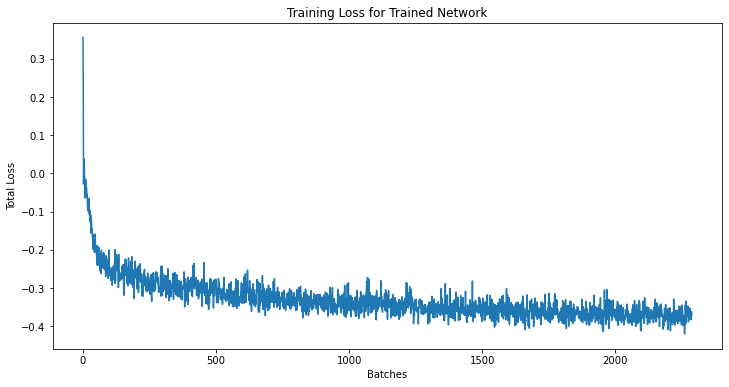

In [30]:
%matplotlib inline

loss_graph = np.load('train_net.npy', allow_pickle=True)
plt.figure(figsize=(12,6))
plt.title('Training Loss for Trained Network')
ax = plt.gca()
ax.set_xlabel('Batches')
ax.set_ylabel('Total Loss')
plt.plot(loss_graph)
plt.show()

In [32]:
validate(val_loader, 8, 'train_net', save_every_epoch=1)

Starting Validation...
Batch Done: ........................................
Epoch: 0 Average Loss: -0.07659043977037072
Batch Done: ........................................
Epoch: 1 Average Loss: -0.10967331228312105
Batch Done: ........................................
Epoch: 2 Average Loss: -0.11423352400306612
Batch Done: ........................................
Epoch: 3 Average Loss: -0.12628256864845752
Batch Done: ........................................
Epoch: 4 Average Loss: -0.13026406008284538
Batch Done: ........................................
Epoch: 5 Average Loss: -0.13257008504588158
Batch Done: ........................................
Epoch: 6 Average Loss: -0.12442116071470082
Batch Done: ........................................
Epoch: 7 Average Loss: -0.12856437109876423


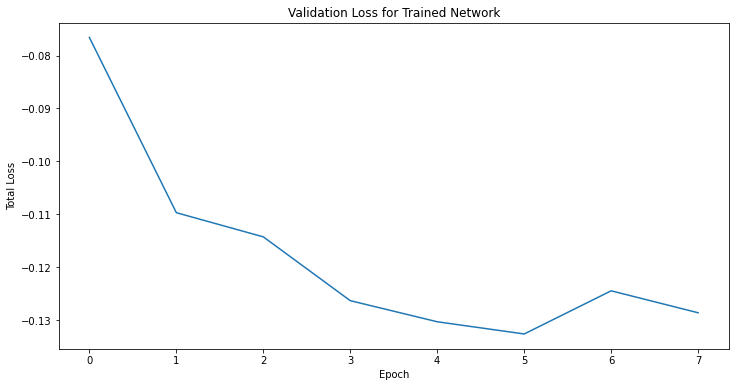

Epoch 5 of the trained network will be used!


In [12]:
%matplotlib inline

loss_graph = np.load('train_net.val.npy', allow_pickle=True)
best_epoch = np.argmin(loss_graph)
best_model = 'train_net.{}.dat'.format(best_epoch)
plt.figure(figsize=(12,6))
plt.title('Validation Loss for Trained Network')
ax = plt.gca()
ax.set_xlabel('Epoch')
ax.set_ylabel('Total Loss')
plt.plot(loss_graph)
plt.show()
print('Epoch {} of the trained network will be used!'.format(best_epoch))

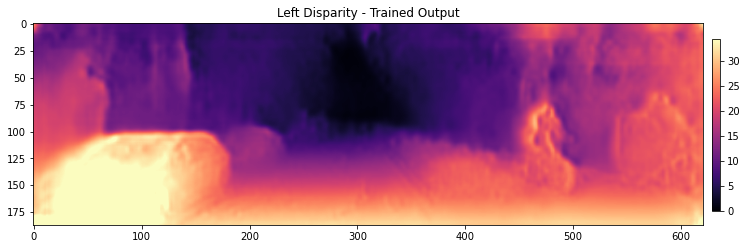

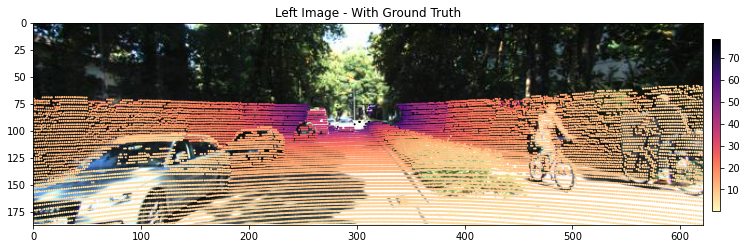

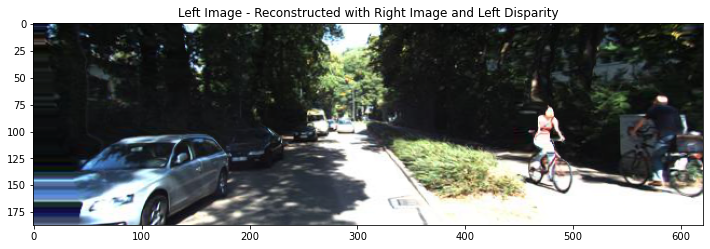

In [26]:
%matplotlib inline

# Change this number for different images in the validation set!
# Range from 0 to 939, inclusive
idx = 0

def ShowResult(idx):
    sample_left, sample_right = validation_dataset[[idx]]
    train_net = MyNet()

    if USE_GPU:
        sample_left = sample_left.cuda()
        sample_right = sample_right.cuda()
        train_net = MyNet().cuda()

    train_net.load_state_dict(torch.load(best_model))
    train_net.eval()
    train_output = train_net.forward(sample_left)

    plt.figure(figsize=(12,6))
    plt.title('Left Disparity - Trained Output')
    plt.imshow(train_output.cpu()[0].view(IMAGE_SIZE).detach().numpy() * MAX_DISPARITY, 
               vmin=0, vmax=torch.quantile(train_output.flatten() * MAX_DISPARITY, 0.95), cmap='magma')
    plt.colorbar(cax=plt.axes([0.91, 0.3, 0.01, 0.4]))
    plt.show()

    sample_left_gt = Unnormalize()(sample_left[0])
    sample_scanned_left, _ = validation_dataset.GetGroundTruth(idx)
    plt.figure(figsize=(12,6))
    plt.title('Left Image - With Ground Truth')
    PlotGroundTruth(plt, tF.to_pil_image(sample_left_gt), sample_scanned_left)
    plt.show()

    sample_left_pred = ApplyDisparity(sample_right, train_output)
    sample_left_pred = Unnormalize()(sample_left_pred[0])
    plt.figure(figsize=(12,6))
    plt.title('Left Image - Reconstructed with Right Image and Left Disparity')
    plt.imshow(tF.to_pil_image(sample_left_pred))
    plt.show()

ShowResult(idx)

## Discussion
The resultant network is able to produce the general depth of the scene at the large-scale, but fails at the smaller-scales with the following problems:

### Heavy Overfitting
Heavy overfitting can be seen when comparing the training and validation loss, at around -0.35 and -0.13 respectively. I believe this is simply due to the lack of training data. Considering the fact that there are only 13708 pairs of images, and that they are not independent to each other since they come from only 36 video clips, the training dataset is quite weak.

Another overfitting problem that occurs is that it overfits and performs well to images with open sky, clear road ahead with cars around and some plants, which makes up most of the training set. From the example above (idx=0), the response and clarity corresponding to the cyclists/pedestrians is much weaker than the cars on the left, and on the following example (idx=600) with the overhead bridge, it performed very poorly.

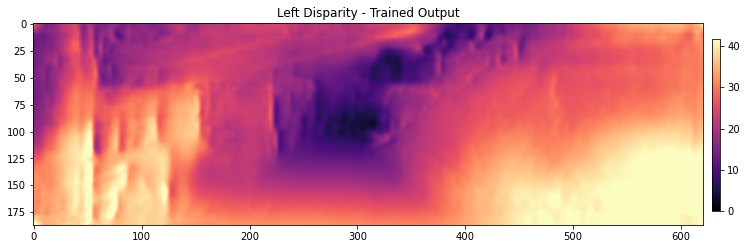

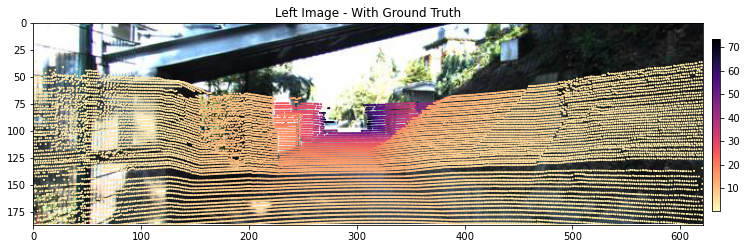

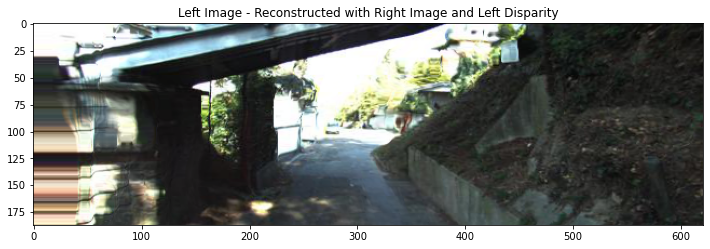

In [59]:
ShowResult(600)

### Texture-Copying Artifact
This implementation also results in heavy texture-copying artifact, as pointed out in the original paper. Specificly, at vertical edges on the original image, there seems to be a very strong response that looks like the x-direction Gaussian gradient:

<img src="images/2dgaussian.jpg" width="100" height="100"/>

This can be seen from most of the examples. In the original paper, this problem was solved by creating a seperate network that predicts the right disparity map as well, and adds the training losses from both the left and right disparity maps, along with an additional term that enforces consistency between the left and right disparity maps. This added simmetry was shown to reduce artifacts in the original paper. (No LR is this project's implementation):

<img src="images/texturecopy.jpg"/>


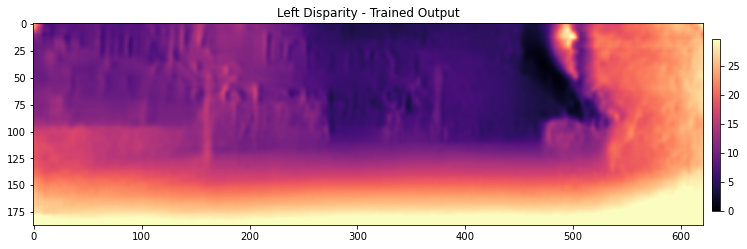

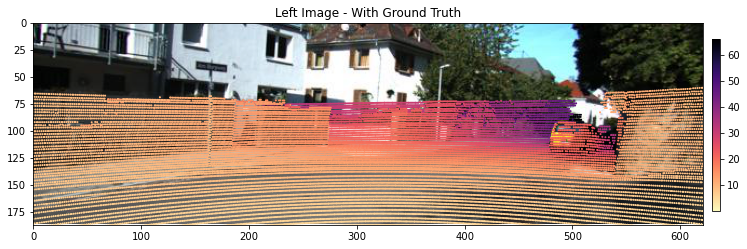

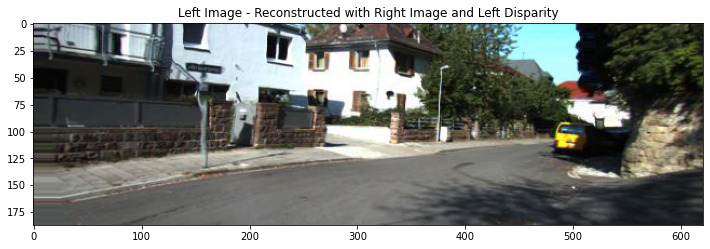

In [62]:
ShowResult(880)

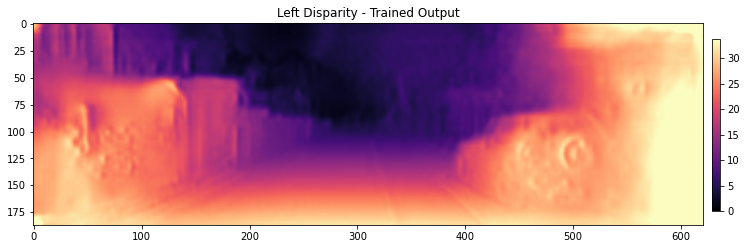

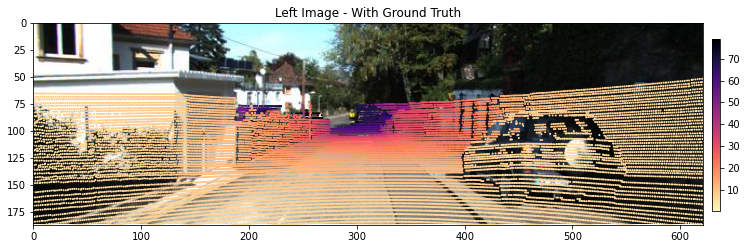

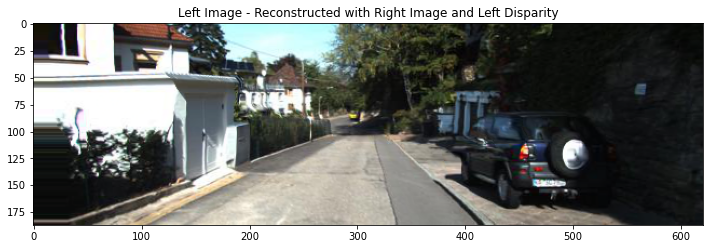

In [72]:
ShowResult(750)

## Conclusion
This project demonstrates an end-to-end self-supervised training method for monocular depth estimation using stereo and  rectified image pairs, as proposed in a paper in 2017 (Godard et al., 2017). The simplified (No LR) version proposed in the paper is implemented in this project. To reduce training time, liberty was taken to reduce the image size, and to use ResNet18 instead of ResNet50 as proposed in the paper. Videos from the KITTI dataset is used for the project, which are manually selected and seperated into training and validation data.

The resulting network is able to create good depth at the larger scale, especially for images with a clear road ahead, and an open sky. However, it fails at resolving small details, with prominent texture-copying artifacts and overfitted quite heavily.

A larger dataset, accompanied by a larger resolution and deeper UNet should help the performance a lot, at the expense of training time. The final architecture proposed in the original paper should also help with reducing the texture-copying artifact. A subsequent paper by the same individuals also proposed a new way of self-supervision, which uses and exploits the time-dependent nature of a monocular video, instead of stereo image pairs, which was shown to provide an even better performance that the previous methods (Godard et al., 2019).

## References

Geiger, A., Lenz, P., Stiller, C., & Urtasun, R. (2013). Vision meets robotics: The kitti dataset. *The International Journal of Robotics Research*, 32(11), 1231-1237.

Godard, C., Mac Aodha, O., Firman, M., & Brostow, G. J. (2019). Digging into self-supervised monocular depth estimation. In *Proceedings of the IEEE/CVF International Conference on Computer Vision* (pp. 3828-3838).

Godard, C., Mac Aodha, O., & Brostow, G. J. (2017). Unsupervised monocular depth estimation with left-right consistency. In *Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition* (pp. 270-279).

Wang, Z., Bovik, A. C., Sheikh, H. R., & Simoncelli, E. P. (2004). Image quality assessment: from error visibility to structural similarity. *IEEE transactions on image processing*, *13*(4), 600-612.